In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import datashader as ds
from datashader.colors import Elevation
from datashader.transfer_functions import shade, stack, dynspread, set_background

## Load Shapefile

In [23]:
df_geom = gpd.read_file("../dataset/shp/america/sea_grid_count_americas.shp")
df_geom = df_geom[["NUMPOINTS", "geometry"]]
df_geom["ZONE_ID"] = range(1, len(df_geom) + 1)
df_geom.head()

,NUMPOINTS,geometry,ZONE_ID
0,0.0,"POLYGON ((43.68476 -12.35978, 43.68476 -12.323...",1
1,0.0,"POLYGON ((30.40476 -3.66758, 30.40476 -3.19368...",2
2,0.0,"POLYGON ((37.04476 -2.69547, 37.04476 -2.36368...",3
3,0.0,"POLYGON ((20.44476 -34.73368, 20.08328 -34.733...",4
4,0.0,"POLYGON ((20.44476 -34.73368, 20.44476 -35.563...",5


In [5]:
df_geom.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   NUMPOINTS  1141 non-null   float64 
 1   geometry   1141 non-null   geometry
 2   ZONE_ID    1141 non-null   int64   
dtypes: float64(1), geometry(1), int64(1)
memory usage: 26.9 KB


## Load Raster

In [27]:
ds_raster = xr.open_dataset("../dataset/copernicus_marine/america/cmems_mod_glo_phy-so_anfc_0.083deg_P1D-m_so_20.00E-58.00E_34.00S-4.00N_0.49m_2021-09-01-2023-11-30.nc")
ds_raster

<xarray.Dataset> Size: 686MB
Dimensions:    (depth: 1, latitude: 457, longitude: 457, time: 821)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 2kB -34.0 -33.92 -33.83 ... 3.833 3.917 4.0
  * longitude  (longitude) float32 2kB 20.0 20.08 20.17 ... 57.83 57.92 58.0
  * time       (time) datetime64[ns] 7kB 2021-09-01 2021-09-02 ... 2023-11-30
Data variables:
    so         (time, depth, latitude, longitude) float32 686MB ...
Attributes:
    Conventions:               CF-1.8
    area:                      Global
    contact:                   https://marine.copernicus.eu/contact
    credit:                    E.U. Copernicus Marine Service Information (CM...
    institution:               Mercator Ocean International
    licence:                   http://marine.copernicus.eu/services-portfolio...
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    references:                http://marine.copernicus.eu
    source:                    MOI GLO12
    title:                     daily mean fields from Global Ocean Physics An...
    copernicusmarine_version:  1.1.1

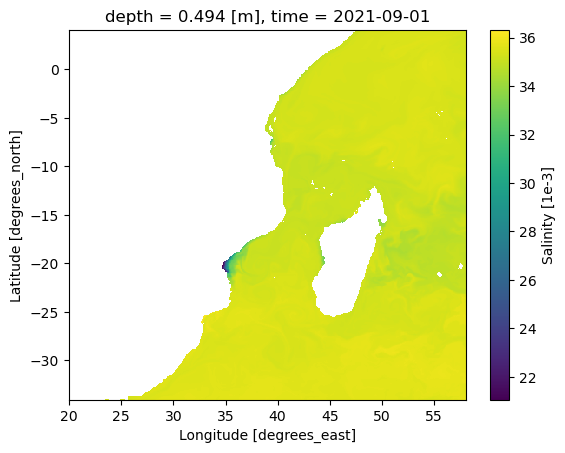

In [29]:
ds_raster.so[0].plot()

In [30]:
ds_raster["so"].sel(time="2021-11-01")

<xarray.DataArray 'so' (depth: 1, latitude: 457, longitude: 457)> Size: 835kB
[208849 values with dtype=float32]
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 2kB -34.0 -33.92 -33.83 ... 3.833 3.917 4.0
  * longitude  (longitude) float32 2kB 20.0 20.08 20.17 ... 57.83 57.92 58.0
    time       datetime64[ns] 8B 2021-11-01
Attributes:
    cell_methods:   area: mean
    long_name:      Salinity
    standard_name:  sea_water_salinity
    unit_long:      Practical Salinity Unit
    units:          1e-3
    valid_max:      50.0
    valid_min:      0.0

## Occurence + Zone

In [5]:
df_occ = pd.read_csv("../dataset/darwin_humpback_whale/occurence_proc.csv", parse_dates=["ts"])
df_occ["ts_date"] = df_occ["ts"].dt.strftime("%Y-%m-%d")
df_occ.head()

,ts,latitude,longitude,species,ts_date
0,2023-11-30 09:44:11,-25.363597,46.837436,Megaptera novaeangliae,2023-11-30
1,2023-11-21 00:00:00,-21.220602,55.205602,Megaptera novaeangliae,2023-11-21
2,2023-11-19 16:19:50,-33.476485,115.064949,Megaptera novaeangliae,2023-11-19
3,2023-11-14 00:00:00,-21.235409,55.226194,Megaptera novaeangliae,2023-11-14
4,2023-11-13 00:00:00,-21.269454,55.201475,Megaptera novaeangliae,2023-11-13


In [6]:
df_occ_points = gpd.GeoDataFrame(df_occ, geometry=gpd.points_from_xy(df_occ["longitude"], df_occ["latitude"]), crs="EPSG:4326")
df_occ_points.head()

,ts,latitude,longitude,species,ts_date,geometry
0,2023-11-30 09:44:11,-25.363597,46.837436,Megaptera novaeangliae,2023-11-30,POINT (46.83744 -25.36360)
1,2023-11-21 00:00:00,-21.220602,55.205602,Megaptera novaeangliae,2023-11-21,POINT (55.20560 -21.22060)
2,2023-11-19 16:19:50,-33.476485,115.064949,Megaptera novaeangliae,2023-11-19,POINT (115.06495 -33.47648)
3,2023-11-14 00:00:00,-21.235409,55.226194,Megaptera novaeangliae,2023-11-14,POINT (55.22619 -21.23541)
4,2023-11-13 00:00:00,-21.269454,55.201475,Megaptera novaeangliae,2023-11-13,POINT (55.20148 -21.26945)


In [7]:
df_occ_points[df_occ_points["ts_date"] == "2023-11-30"]

,ts,latitude,longitude,species,ts_date,geometry
0,2023-11-30 09:44:11,-25.363597,46.837436,Megaptera novaeangliae,2023-11-30,POINT (46.83744 -25.36360)


## Zonal Stats XR

In [15]:
from xrspatial import zonal_stats

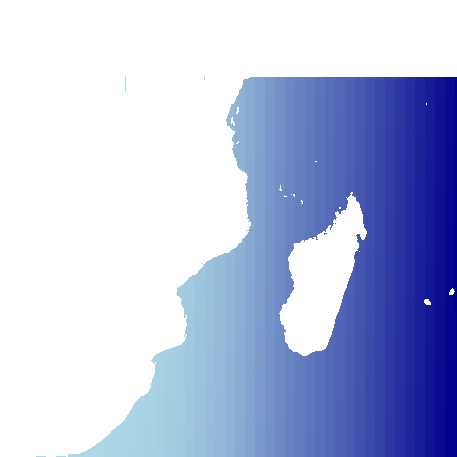

In [41]:
canvas = ds.Canvas(plot_width=ds_raster["so"].shape[2], plot_height=ds_raster["so"].shape[3], y_range=(float(ds_raster.coords["latitude"].min().values), float(ds_raster.coords["latitude"].max().values)), x_range=(float(ds_raster.coords["longitude"].min().values), float(ds_raster.coords["longitude"].max().values)))
agg = canvas.polygons(df_geom, geometry="geometry", agg=ds.max("ZONE_ID"))
shade(agg)

In [42]:
ds_raster["so"].sel(time="2021-11-01")

<xarray.DataArray 'so' (depth: 1, latitude: 457, longitude: 457)> Size: 835kB
[208849 values with dtype=float32]
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 2kB -34.0 -33.92 -33.83 ... 3.833 3.917 4.0
  * longitude  (longitude) float32 2kB 20.0 20.08 20.17 ... 57.83 57.92 58.0
    time       datetime64[ns] 8B 2021-11-01
Attributes:
    cell_methods:   area: mean
    long_name:      Salinity
    standard_name:  sea_water_salinity
    unit_long:      Practical Salinity Unit
    units:          1e-3
    valid_max:      50.0
    valid_min:      0.0

In [47]:
ds_raster["so"].depth[0]

<xarray.DataArray 'depth' ()> Size: 4B
array(0.494025, dtype=float32)
Coordinates:
    depth    float32 4B 0.494
Attributes:
    axis:           Z
    long_name:      Depth
    positive:       down
    standard_name:  depth
    unit_long:      Meters
    units:          m
    valid_max:      0.494025
    valid_min:      0.494025

In [49]:
df_zonal = zonal_stats(agg, ds_raster["so"].sel(time="2021-11-01", depth=ds_raster["so"].depth[0]), zone_ids=df_geom["ZONE_ID"])
df_zonal

,zone,mean,max,min,sum,std,var,count
0,1,35.122551,35.122551,35.122551,35.122551,0.000000,0.000000,1.0
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,35.189583,35.203011,35.176197,140.758331,0.012588,0.000158,4.0
4,16,35.337410,35.360973,35.313362,212.024460,0.016261,0.000264,6.0
...,...,...,...,...,...,...,...,...
1042,1096,35.644451,35.658978,35.629421,712.889038,0.008113,0.000066,20.0
1043,1097,35.631630,35.650730,35.600563,712.632629,0.015400,0.000237,20.0
1044,1098,35.593468,35.621300,35.554646,711.869324,0.019717,0.000389,20.0
1045,1099,35.657860,35.707878,35.605854,713.157166,0.032754,0.001073,20.0


In [19]:
df_zonal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   zone    1041 non-null   float64
 1   mean    1031 non-null   float64
 2   max     1031 non-null   float64
 3   min     1031 non-null   float64
 4   sum     1031 non-null   float64
 5   std     1031 non-null   float64
 6   var     1031 non-null   float64
 7   count   1031 non-null   float64
dtypes: float64(8)
memory usage: 65.2 KB
